# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1 Импорт необходимых библиотек и открытие файла csv

In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [5]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

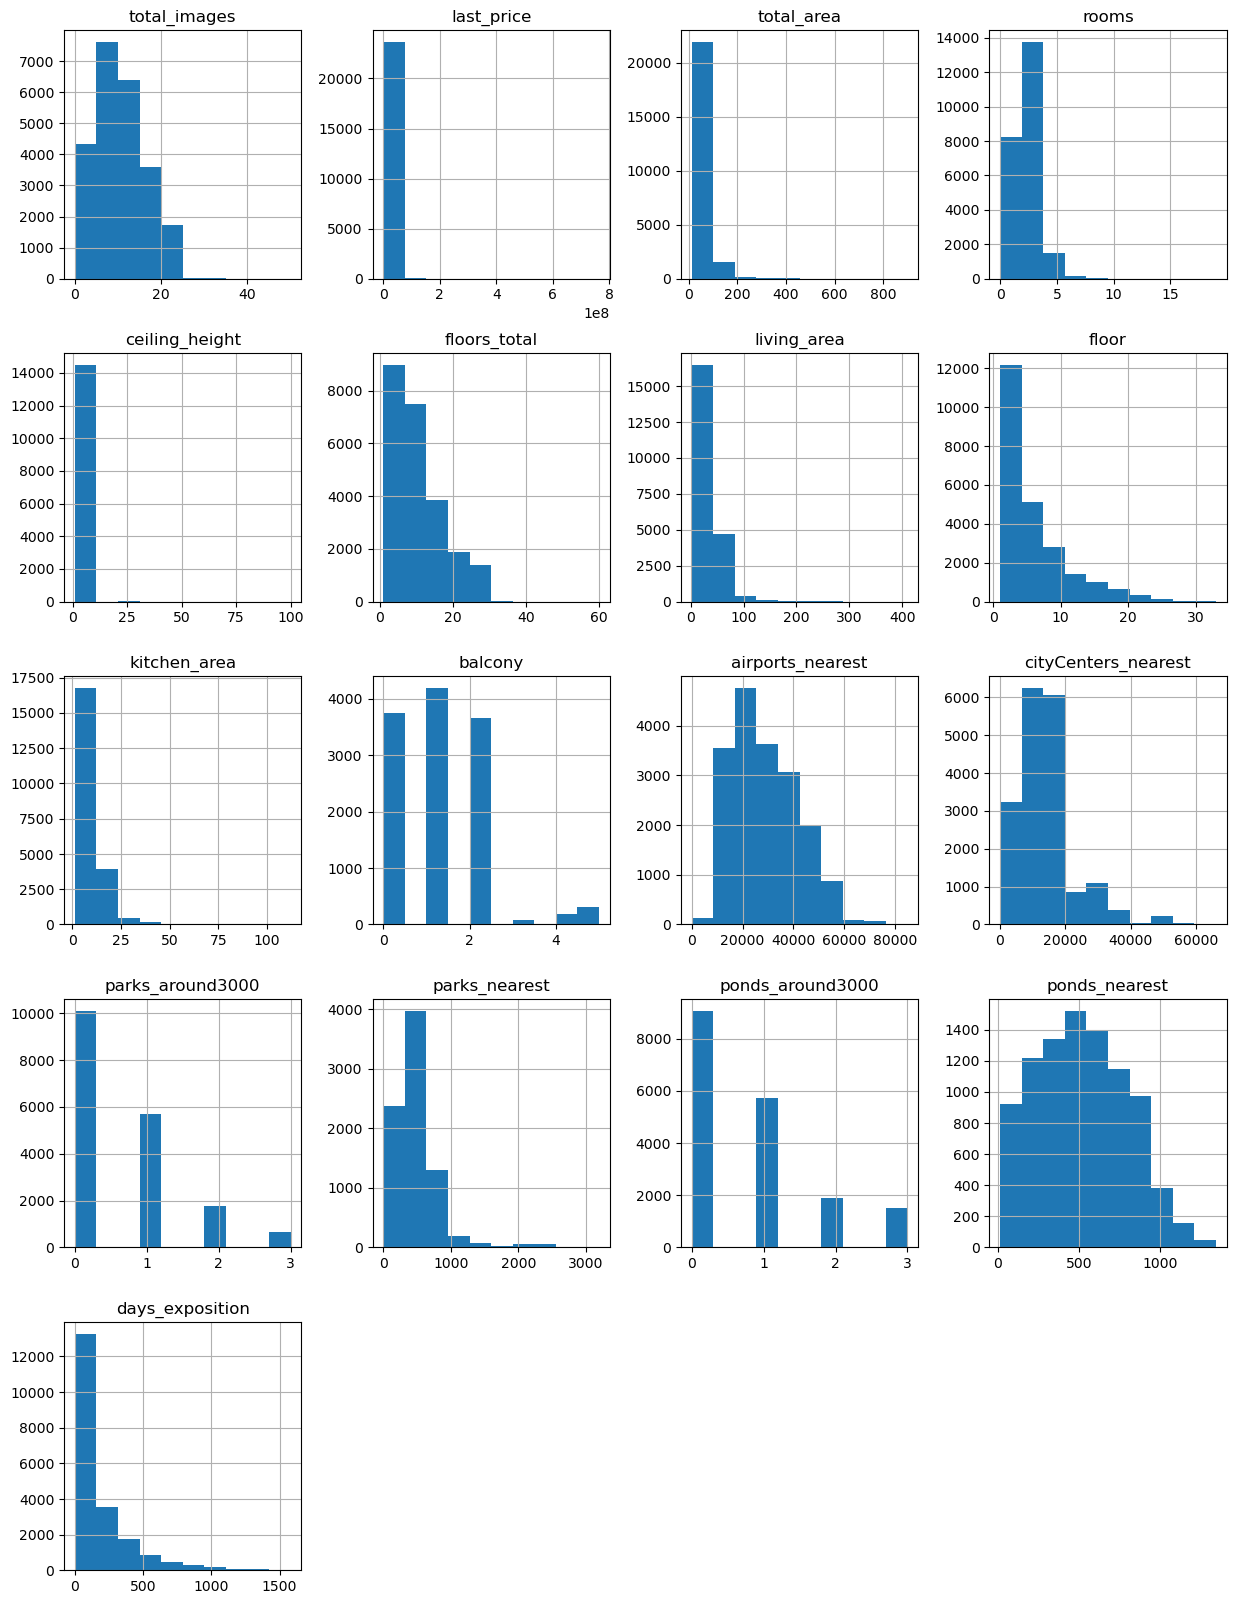

In [6]:
data.hist(figsize=(15, 20))

Многие столбцы имеют пропуски и есть ошибки в типах данных и названиях столбцов. 
Если удалить строчки с пропусками из всей таблицы возможно мы потеряем другие ценные данные и анализ будет сильно искажен.
Также есть возможнось что пропуски в таблице логически обоснованы. 

### 2 Предобработка данных

Столбец cityCenters_nearest некорректно назван.
Испавим это:

In [7]:
data.rename(columns = {'cityCenters_nearest' : 'city_сenters_nearest'}, inplace = True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_сenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Для каждого столбца нужно проверить наличие пропусков, соответсвие типов данных, наличие дубликатов и ошибочных значений.

In [8]:
data['total_images'].value_counts()

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
27       2
30       2
35       2
31       2
42       1
25       1
39       1
37       1
Name: total_images, dtype: int64

В столбце total_images нет пустых или ошибочных значений требующих обработки

In [9]:
data[data['last_price'] <=0]['last_price'].count()

0

In [10]:
data['last_price'].sort_values()
data.drop(labels = [8793],axis=0, inplace = True)

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23699, dtype: float64

В столбце last_price нет пропусков, отрицательных или нулевых значений. Но есть строчка с подозрительно низкой стоимость квартиры, скорее всего продавец ошибся в цене, можно удалить эту строчку т.к. она не коректная.

19904     12.0
17961     13.0
19807     13.0
19546     13.0
19558     13.2
         ...  
5358     590.0
15651    618.0
3117     631.0
12859    631.2
19540    900.0
Name: total_area, Length: 23698, dtype: float64

<AxesSubplot:>

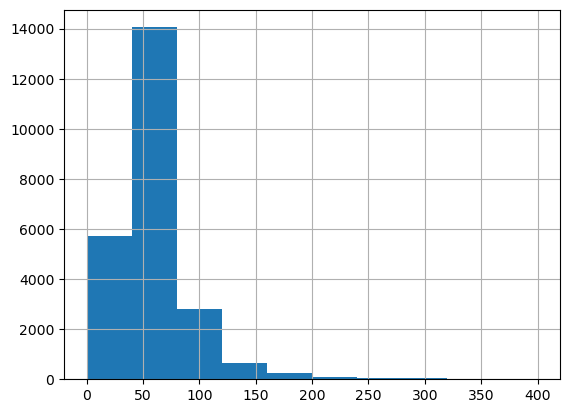

In [11]:
data['total_area'].sort_values()
data['total_area'].hist(range=(0,400))

В столбце total_area нет пропусков или ошибочных значений.

In [12]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y/%m/%d')

В столбце указаны только даты с нулевым значением времени. Для удобства учше перевести формат даты в дату без времени. 

In [13]:
data['rooms'].sort_values()
data[data['rooms'] == 0]['studio'].count()
data[data['rooms'] == 1]['studio'].count()

9412      0
8886      0
18132     0
20002     0
21425     0
         ..
866      14
20829    14
5358     15
18848    16
14498    19
Name: rooms, Length: 23698, dtype: int64

197

8047

В столбце room присутсвуют нулевые значения. Возможно это связано с тем считают ли люди студию за однокомнатную квартиру или нет.

In [14]:
np.sort(data['ceiling_height'].unique())

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [15]:
data = data.query('ceiling_height > 2 and ceiling_height < 10')
data['ceiling_height'].describe()

count    14464.000000
mean         2.728825
std          0.291940
min          2.200000
25%          2.520000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

В столбце ceiling_height есть пропуски и ошибочные значения. Если допустить что потолки ниже 2ух метров и выше 10
являются ошибочными можно оставить их без изменений т.к. 28 строк не смогут исказить общее распределение.
Количество пропусков достаточно велико для того чтобы заменить пропуски медианой.
По всей видимости при подаче обьявления люди не считают высоту потолка важным параметром для заполнения.

In [16]:
data['floors_total'] = data['floors_total'].astype('Int64')
data['floors_total'].value_counts()
data['floors_total'].describe()

5     3651
9     2554
16     864
12     851
4      788
10     749
6      618
25     521
17     501
3      398
7      398
14     341
18     274
15     224
8      220
24     216
2      211
23     196
20     156
22     141
19     134
13     117
11     109
27      72
21      65
26      54
1       10
28       9
35       8
34       1
60       1
29       1
36       1
52       1
Name: floors_total, dtype: Int64

count    14455.000000
mean        10.172466
std          6.193666
min          1.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         60.000000
Name: floors_total, dtype: float64

В столбце floors_total присутствуют нулевые значения, их можно заполнить во время исследования.
Также я изменил тип данных столбца на Int64 чтобы можно было оставить пустые значения.

In [17]:
data[data['floors_total'] == 60]


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,NaN,...,7.4,NaN,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0


In [18]:
data.drop(labels = [2253],axis=0, inplace = True)

In [19]:
len(data[data['living_area'].isna() | data['kitchen_area'].isna()]['living_area'])

1161

В столбце living_area достаточно много пропусков и они перекликаются с пропусками в kitchen_area. 
Можно заполнить значения если есть данные из одного столбца путем вычета из общей площади, но это будет грубый подсчет т.к. 
не будут учтены остальные подсобные помещения.


In [20]:
data['floor'].describe()
data['floor'].value_counts()

count    14463.000000
mean         5.623453
std          4.615647
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         30.000000
Name: floor, dtype: float64

2     2125
3     1917
1     1817
4     1796
5     1656
6      791
7      768
8      658
9      633
10     395
11     300
12     288
13     217
15     184
16     175
14     172
17     115
18      86
19      78
21      66
20      60
22      51
23      49
24      26
25      23
26      11
27       4
30       1
29       1
Name: floor, dtype: int64

В столбце floor нет отрицательных значений.

In [21]:
#data['is_apartment'].isna().sum()
data[data['is_apartment'] == True] 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
543,11,12790000.0,56.60,2018-11-06,2,3.50,3,29.400000,1,True,...,NaN,NaN,Петергоф,35248.0,30437.0,3.0,53.0,3.0,22.0,NaN
916,11,8183000.0,70.00,2018-01-11,2,3.12,3,40.000000,3,True,...,NaN,2.0,Санкт-Петербург,45796.0,21729.0,0.0,NaN,1.0,754.0,179.0
2759,11,7500000.0,152.00,2018-07-27,3,3.00,3,NaN,1,True,...,NaN,1.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2975,9,4931398.0,42.90,2018-07-23,1,3.15,4,20.390000,3,True,...,10.29,NaN,Санкт-Петербург,44870.0,20802.0,0.0,NaN,1.0,792.0,273.0
3067,13,6600000.0,95.00,2018-09-08,2,4.50,7,45.000000,7,True,...,25.00,2.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,96.0
3951,10,4300000.0,50.00,2019-04-20,1,3.00,11,17.000000,9,True,...,12.00,2.0,Санкт-Петербург,10143.0,11367.0,0.0,NaN,0.0,NaN,NaN
4339,19,6900000.0,72.00,2019-03-25,3,3.50,4,70.000000,1,True,...,NaN,NaN,Санкт-Петербург,31487.0,4466.0,2.0,353.0,1.0,439.0,22.0
5297,19,45000000.0,96.00,2018-11-15,2,3.20,6,NaN,4,True,...,45.00,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,NaN
5654,20,9200000.0,116.00,2019-04-26,3,3.20,5,68.000000,5,True,...,32.00,2.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5809,10,7900000.0,74.00,2019-02-12,3,3.55,6,56.000000,3,True,...,NaN,NaN,Санкт-Петербург,31006.0,3075.0,2.0,123.0,3.0,274.0,6.0


Т.к. из всей выборки всего 50 строчек в столбце is_apartment имеют значение True можно сделать вывод что пропущенные значения можно отнечти к False. Т.е. недвижимость с пропущенными значениями не являются апартаментами. Также можно будет поменять тип данных на boolean.

In [22]:
data['is_apartment'] = data['is_apartment'].fillna(False)

In [23]:
data['is_apartment'].astype('bool')

0        False
4        False
9        False
10       False
13       False
         ...  
23691    False
23693    False
23694    False
23697    False
23698    False
Name: is_apartment, Length: 14463, dtype: bool

In [24]:
data['balcony'] = data['balcony'].fillna(0)

В столбце balcony есть пропуски. Допустим что пользователи не указали количество балконов по причинеотсутствия.

In [25]:
data['locality_name'].unique()
len(data['locality_name'].unique())

array(['Санкт-Петербург', 'Петергоф', 'посёлок Парголово',
       'деревня Кудрово', 'Пушкин', 'поселок городского типа Красный Бор',
       'посёлок Мурино', 'Сертолово', 'Гатчина', 'поселок Мурино',
       'Ломоносов', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Колпино', 'Кировск', 'деревня Новое Девяткино',
       'посёлок городского типа Сиверский',
       'садовое товарищество Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'поселок городского типа Кузьмоловский', 'деревня Куттузи',
       'поселок Торковичи', 'посёлок Шушары', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'село Путилово',
       'Ивангород', 'Сланцы', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'деревня Оржицы', 'деревня Кальтино', 'Кудрово',
       'поселок городского типа Рощино', 'Сясьстрой', 'Кириши', 'Луга',
       'Волосово', 'по

282

In [26]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')

In [27]:
data['locality_name'].unique()
len(data['locality_name'].unique())

array(['Санкт-Петербург', 'Петергоф', 'поселок Парголово',
       'деревня Кудрово', 'Пушкин', 'поселок городского типа Красный Бор',
       'поселок Мурино', 'Сертолово', 'Гатчина', 'Ломоносов',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Колпино', 'Кировск',
       'деревня Новое Девяткино', 'поселок городского типа Сиверский',
       'садовое товарищество Новая Ропша', 'Павловск', 'Всеволожск',
       'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'поселок городского типа Кузьмоловский', 'деревня Куттузи',
       'поселок Торковичи', 'поселок Шушары', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'село Путилово',
       'Ивангород', 'Сланцы', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'деревня Оржицы', 'деревня Кальтино', 'Кудрово',
       'поселок городского типа Рощино', 'Сясьстрой', 'Кириши', 'Луга',
       'Волосово', 'поселок Оредеж', 'поселок Б

257

В столбце locality_name было 34 повтора связанных с написанием населенных пунктов через ё или е. По всей видимости пользователи сами пишут названия в объявлениях. Я бы рекомендовал сделать выбор населенного пункта через список или автоматически присваевать его через геопозицию.

Вывод: 
При просмотре таблицы на ошибки было выявленно большое количество ошибок связанных с заполнением форм пользователями. Я порекомендовал бы заменить по возможности формы с свободным в водом на ввод через список и где это невозможно сделать автоматическу проверку на ошибку указывая пользователю что значение слишком отличается от стандартного.

### 3 Посчитайте и добавьте в таблицу новые столбцы

Необходимо добавить в таблицу столбцы со следующими параметрами:
<ul>
<li>цена одного квадратного метра;</li>
<li>день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);</li>
<li>месяц публикации объявления;</li>
<li>год публикации объявления;</li>
<li>тип этажа квартиры (значения — «первый», «последний», «другой»);</li>
<li>расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).</li>

Начнем с цены одного квадратного метра. Небходимо стоимось недвижимости last_price поделить на общую площадь total_area. 
Назовем столбец price_per_smeter.

In [28]:
data['price_per_smeter'] = data['last_price'] / data['total_area']
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_smeter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,0.0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,1.0,Петергоф,37868.0,33058.0,1.0,294.0,3.0,298.0,366.0,82943.925234
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,0.0,Санкт-Петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0,81707.317073
18,8,3250000.0,31.0,2017-01-27,1,2.50,5,19.4,2,False,...,1.0,Санкт-Петербург,44060.0,10842.0,1.0,759.0,0.0,NaN,168.0,104838.709677
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,0.0,Санкт-Петербург,38900.0,12843.0,0.0,NaN,0.0,NaN,97.0,117355.371901
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,2.0,поселок Парголово,53134.0,19311.0,0.0,NaN,0.0,NaN,74.0,76500.000000
22,20,5000000.0,58.0,2017-04-24,2,2.75,25,30.0,15,False,...,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0,86206.896552


In [29]:
data['exposition_day_of_week'] = data['first_day_exposition'].dt.dayofweek
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_year'] = data['first_day_exposition'].dt.year
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_smeter,exposition_day_of_week,exposition_month,exposition_year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164,6,2,2017
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,13878.0,1.0,310.0,2.0,553.0,137.0,127525.252525,3,11,2017
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,33058.0,1.0,294.0,3.0,298.0,366.0,82943.925234,5,7,2017
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,10698.0,3.0,420.0,0.0,NaN,397.0,81707.317073,3,11,2017
18,8,3250000.0,31.0,2017-01-27,1,2.50,5,19.4,2,False,...,10842.0,1.0,759.0,0.0,NaN,168.0,104838.709677,4,1,2017
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,12843.0,0.0,NaN,0.0,NaN,97.0,117355.371901,2,1,2019
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,19311.0,0.0,NaN,0.0,NaN,74.0,76500.000000,3,9,2017
22,20,5000000.0,58.0,2017-04-24,2,2.75,25,30.0,15,False,...,NaN,NaN,NaN,NaN,NaN,60.0,86206.896552,0,4,2017


Для поиска типа этажа создадим функцию в которой будет обработчик ошибок в случае если есть пустые значения.

In [30]:
def found_floor_type(df):
    try:
        if df['floor'] == 1:
            return 'первый'
        elif df['floor'] == df['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except: return None
data['floor_type'] = data.apply(found_floor_type,axis=1)

In [31]:
data['city_сenters_nearest_km'] = (data['city_сenters_nearest'].astype('Int64') / 1000).astype('Int64')
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_smeter,exposition_day_of_week,exposition_month,exposition_year,floor_type,city_сenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой,15
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,310.0,2.0,553.0,137.0,127525.252525,3,11,2017,другой,13
13,20,3550000.0,42.8,2017-07-01,2,2.56,5,27.0,5,False,...,294.0,3.0,298.0,366.0,82943.925234,5,7,2017,последний,33
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,420.0,0.0,NaN,397.0,81707.317073,3,11,2017,первый,10
18,8,3250000.0,31.0,2017-01-27,1,2.50,5,19.4,2,False,...,759.0,0.0,NaN,168.0,104838.709677,4,1,2017,другой,10
19,16,14200000.0,121.0,2019-01-09,3,2.75,16,76.0,8,False,...,NaN,0.0,NaN,97.0,117355.371901,2,1,2019,другой,12
20,12,6120000.0,80.0,2017-09-28,3,2.70,27,48.0,11,False,...,NaN,0.0,NaN,74.0,76500.000000,3,9,2017,другой,19
22,20,5000000.0,58.0,2017-04-24,2,2.75,25,30.0,15,False,...,NaN,NaN,NaN,60.0,86206.896552,0,4,2017,другой,<NA>


### Проведите исследовательский анализ данных

<AxesSubplot:ylabel='Frequency'>

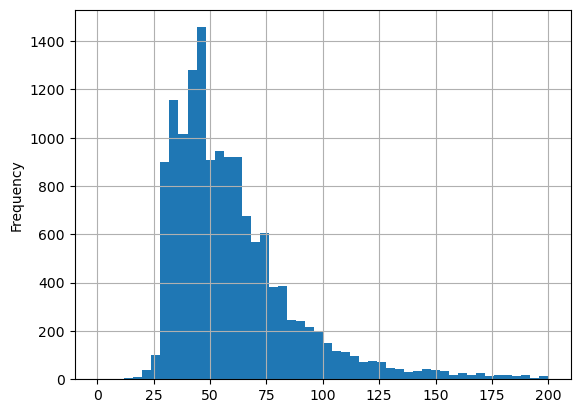

In [32]:
data['total_area'].plot(kind='hist',bins=50, range=(0,200), grid=True)

По гистограмме видно что большинство квартир имеют общую площадь в районе от 30 до 50 кв.м.
Данные похожи на правду т.к. однокомнатные квартиры в новых домах или двухкомнатные квартиры старой планировки имеют общую площать в этом диапазоне и таких квартир в городе большинство.

<AxesSubplot:ylabel='Frequency'>

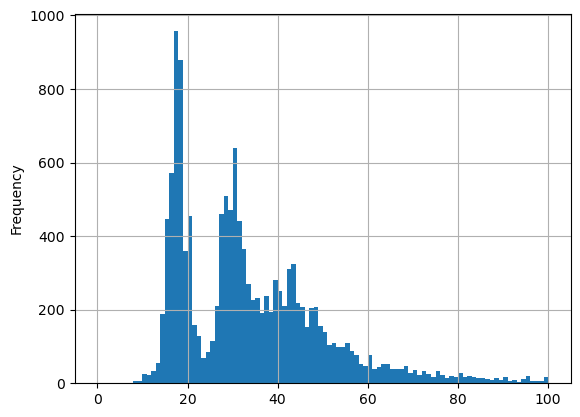

In [33]:
data['living_area'].plot(kind='hist',bins=100, range=(0,100), grid=True)

Ярко выделенная зона до 20 квадратов указывает на жилые площади в диапазоне до 20 кв.м. что скорее соотносится со студиями или однокомнатными квартирами.

<AxesSubplot:ylabel='Frequency'>

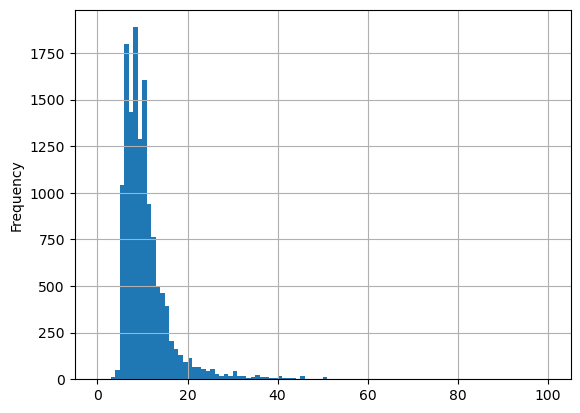

In [34]:
data['kitchen_area'].plot(kind='hist',bins=100, range=(0,100), grid=True)

Гистограмма по площади кухни соответствует предпологаемому распределению.

<AxesSubplot:ylabel='Frequency'>

count    1.446300e+04
mean     6.842980e+06
std      1.019429e+07
min      4.500000e+05
25%      3.578694e+06
50%      4.850000e+06
75%      7.019000e+06
max      4.200000e+08
Name: last_price, dtype: float64

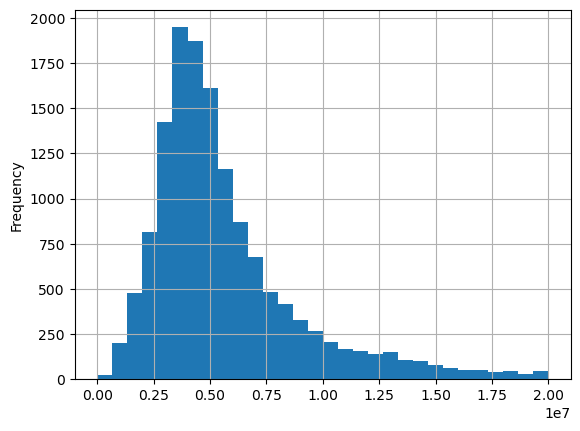

In [35]:
data['last_price'].plot(kind='hist',bins=30,range=(0,20000000), grid=True)
data['last_price'].describe() 

Цены соответсвуют реальным данным. Есть выбросы в большую сторону но это единичный случаи обусловленные большой площадью в центре города.

<AxesSubplot:ylabel='Frequency'>

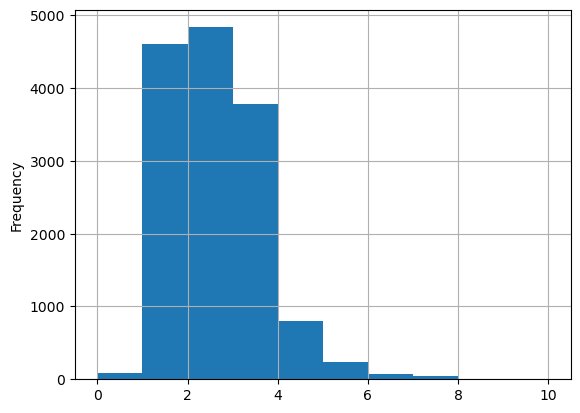

In [36]:
data['rooms'].plot(kind='hist',bins=10,range=(0,10), grid=True)


Большинство квартир это однокомнотные и двухкомнатные квартиры.

<AxesSubplot:ylabel='Frequency'>

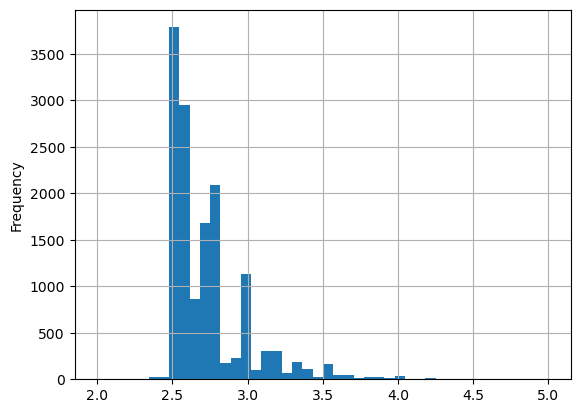

In [37]:
data['ceiling_height'].plot(kind='hist',bins=44,range=(2,5), grid=True)


<AxesSubplot:ylabel='Frequency'>

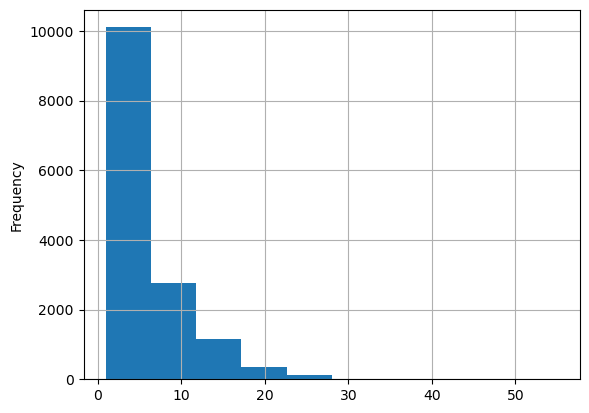

In [38]:
data['floor'].plot(kind='hist',bins=10,range=(1,55), grid=True)

array([<AxesSubplot:ylabel='total_images'>], dtype=object)

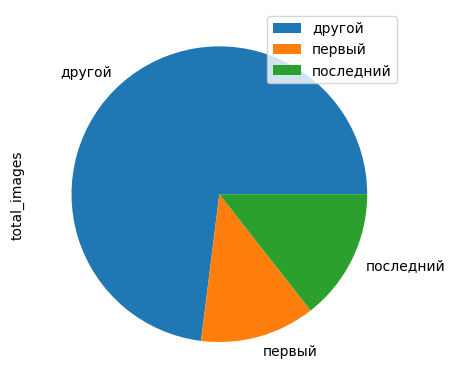

In [39]:
data.pivot_table(index='floor_type', values='total_images',aggfunc='count').plot(kind='pie', subplots=True)

Количество первых этажей немного меньше чем последних, возможно это связанно что первые этажи зачастую исплюзуют в коммерци

count    14454.000000
mean        10.169019
std          6.179996
min          1.000000
25%          5.000000
50%          9.000000
75%         14.000000
max         52.000000
Name: floors_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

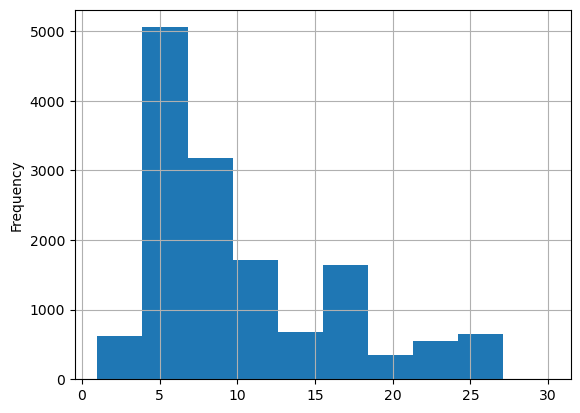

In [40]:
data['floors_total'].describe()
data['floors_total'].plot(kind='hist',bins=10,range=(1,30), grid=True)

в Санкт-Петербуге и Л.О. в основном преобладают хрущевки, сталинки, дома дореволюционной постройки которые не привышают 9 этажей.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Типовые застройки выделяются

count    11537.000000
mean     14062.470660
std       8750.855361
min        181.000000
25%       9041.000000
50%      12952.000000
75%      16034.000000
max      65968.000000
Name: city_сenters_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

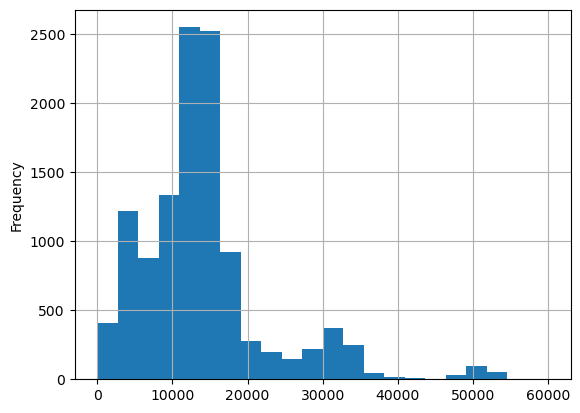

In [41]:
data['city_сenters_nearest'].describe()
data['city_сenters_nearest'].plot(kind='hist', bins=22, range=(1,60000),grid=True)

Радиус Санкт-Петербурга в пределах КАД составляет около 16км что соответствует нашей гистограмме.

count    11517.000000
mean     28816.021533
std      12620.424290
min          0.000000
25%      18551.000000
50%      26736.000000
75%      37083.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

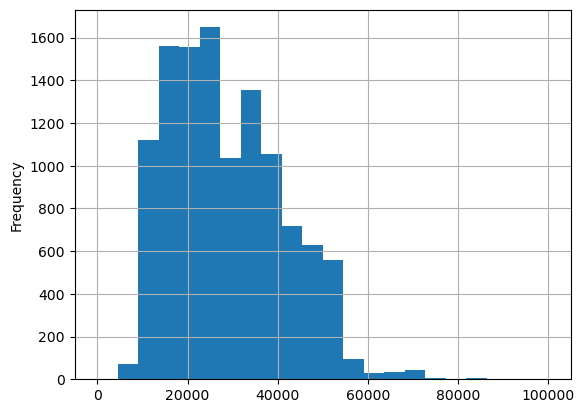

In [42]:
data['airports_nearest'].describe()
data['airports_nearest'].plot(kind='hist', bins=22, range=(1,100000),grid=True)

В Санкт-Петербурке только один аэропорт Пулково. На гистограмме указано расстояние от домов всех населенных пунктов Лен. области до аэропорта. Наверно такая зависимость не очень корректна и полезна. Но для Спб может быть полезна.

count    5281.000000
mean      476.707631
std       320.160548
min         3.000000
25%       285.000000
50%       449.000000
75%       602.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:ylabel='Frequency'>

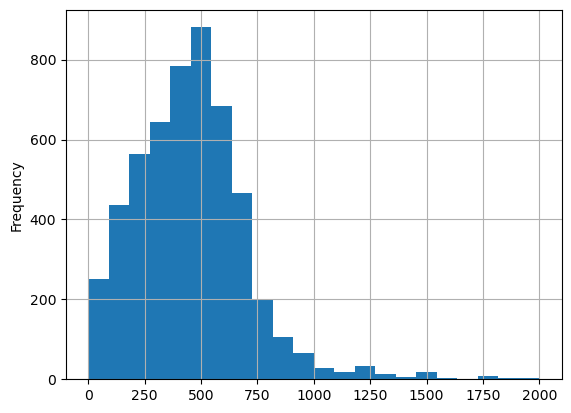

In [43]:
data['parks_nearest'].describe()
data['parks_nearest'].plot(kind='hist', bins=22, range=(1,2000),grid=True)

По графику можно сказать что в основном количество парков достаточно велико и все они в пешей доступности.
Думаю что тут учитываются скверы и сады в жилом массиве иначе такое количесто и плотность сложно обьяснить

,total_images
exposition_day_of_week,
0,2367
1,2631
2,2399
3,2633
4,2299
5,1156
6,978


<AxesSubplot:xlabel='exposition_day_of_week'>

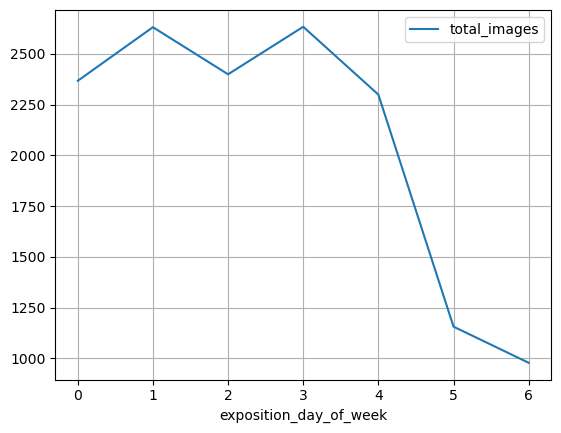

In [44]:
data.pivot_table(index='exposition_day_of_week',values='total_images',aggfunc='count')
data.pivot_table(index='exposition_day_of_week',values='total_images',aggfunc='count').plot(grid='True')

Больше  всего обьявления выставляются в буднии дни. Видимо это связанно с работой фирм по недвижимости.

,total_images
exposition_month,
1,924
2,1686
3,1722
4,1481
5,693
6,910
7,1065
8,1091
9,1213


<AxesSubplot:xlabel='exposition_month'>

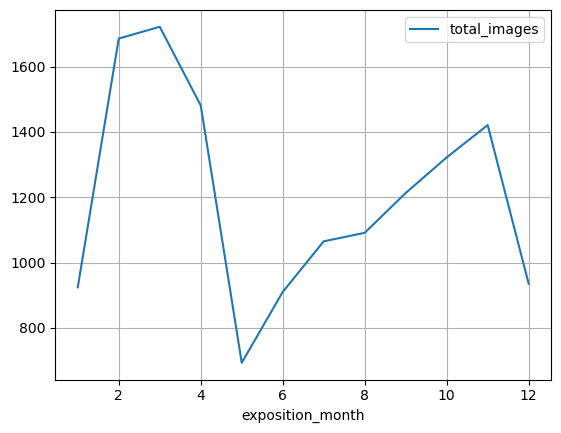

In [45]:
data.pivot_table(index='exposition_month',values='total_images',aggfunc='count')
data.pivot_table(index='exposition_month',values='total_images',aggfunc='count').plot(grid='True')

Больше всего активность по продаже в марте и апреле и снова ростоет к концу года.
Могу предположить что летнее подение связанно с сезоном отпусков а зимнее с новогодними празниками.

In [46]:
data['days_exposition'].describe()
#data.groupby(['days_exposition'])['total_images'].value_counts().sort_values(ascending=False)
#data.query('days_exposition < 232')['days_exposition'].plot(kind='hist', range=(1,400), bins=40)

count    12019.000000
mean       190.594392
std        228.873368
min          1.000000
25%         45.000000
50%        103.000000
75%        248.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:ylabel='Frequency'>

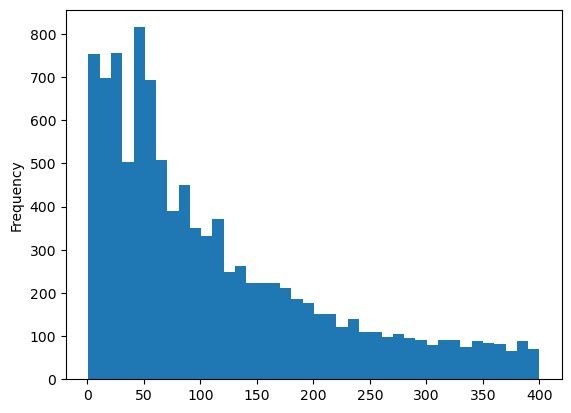

In [47]:
data['days_exposition'].plot(kind='hist', range=(1,400), bins=40)

Все продажи совершенные до 45 можно считать быстрыми, а продажи свыше 232 дней долгими. Чаще всего квартиры продавались за 45 дней.

In [48]:
data.floor_type

0           другой
4           другой
9           другой
10          другой
13       последний
           ...    
23691       другой
23693       другой
23694       другой
23697       другой
23698       первый
Name: floor_type, Length: 14463, dtype: object

0.7132051848716491

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

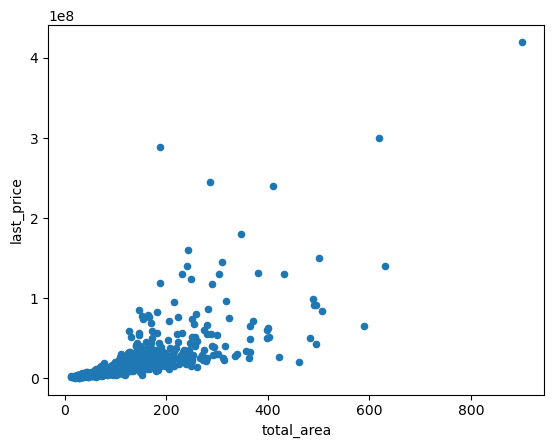

In [49]:
#dt = data[['last_price','total_area','living_area','kitchen_area','rooms','first_day_exposition']]
#pd.plotting.scatter_matrix(dt,figsize=(20,20))
data['total_area'].corr(data['last_price'])
data.groupby('total_area').median()['last_price'].reset_index().sort_values(by='total_area').plot(kind='scatter', x='total_area',y ='last_price')

0.6156113044132754

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

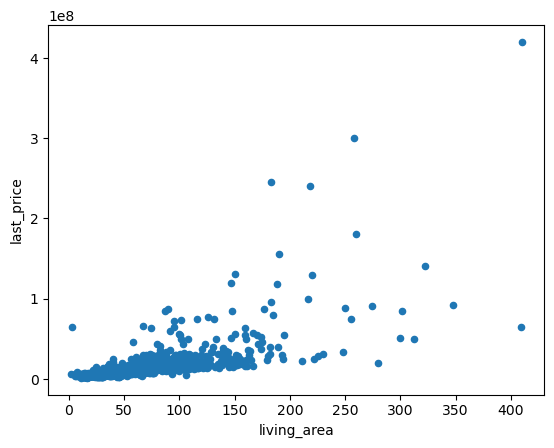

In [50]:
data['living_area'].corr(data['last_price'])
data.groupby('living_area').median()['last_price'].reset_index().sort_values(by='living_area').plot(kind='scatter', x='living_area',y ='last_price')

0.5366245645304548

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

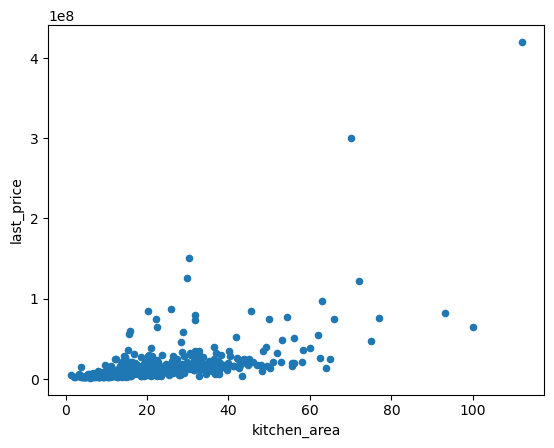

In [51]:
data['kitchen_area'].corr(data['last_price'])
data.groupby('kitchen_area').median()['last_price'].reset_index().sort_values(by='kitchen_area').plot(kind='scatter', x='kitchen_area',y ='last_price')

0.4017054458489554

<AxesSubplot:xlabel='rooms'>

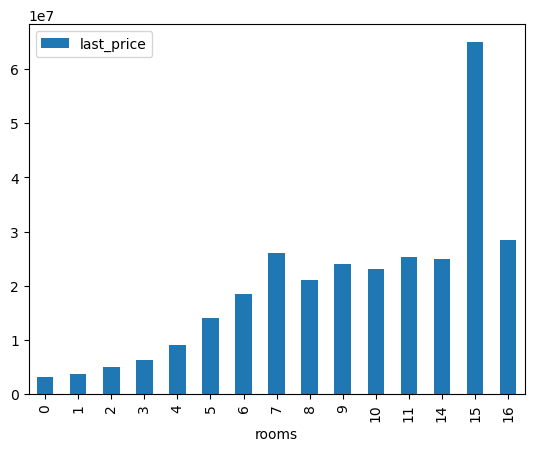

In [52]:
data['rooms'].corr(data['last_price'])
data[data['rooms'] != 12].groupby('rooms').median()['last_price'].reset_index().sort_values(by='rooms').plot(kind='bar', x='rooms',y ='last_price')

При анализе стоимости квартир был обнаружен выброс в виде одного обьекта недвижимости из 12 комнат с очень большой стоимостью. Из графика он был исключен для более точной оценки зависимости.

,floor_type,last_price
0,другой,5000000.0
1,первый,4070000.0
2,последний,4530000.0


<AxesSubplot:xlabel='floor_type'>

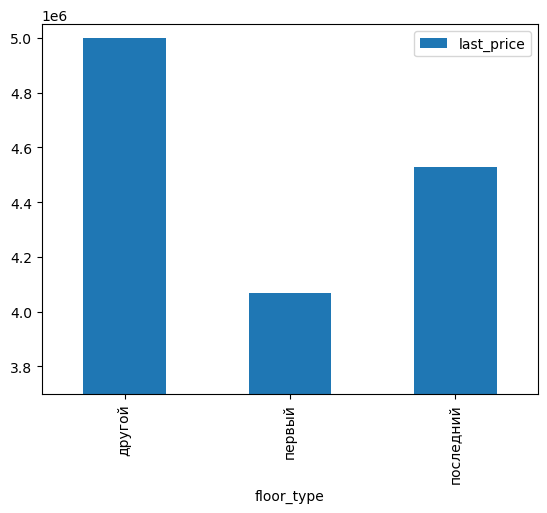

In [53]:
data.groupby('floor_type').median()['last_price'].reset_index().sort_values(by='floor_type')
data.groupby('floor_type').median()['last_price'].reset_index().sort_values(by='floor_type').plot(kind='bar', x='floor_type',ylim=(3700000,5050000.0))

,exposition_day_of_week,last_price
0,0,4900000.0
1,1,5000000.0
2,2,4900000.0
3,3,4890000.0
4,4,4750000.0
5,5,4690000.0
6,6,4700000.0


<AxesSubplot:xlabel='exposition_day_of_week'>

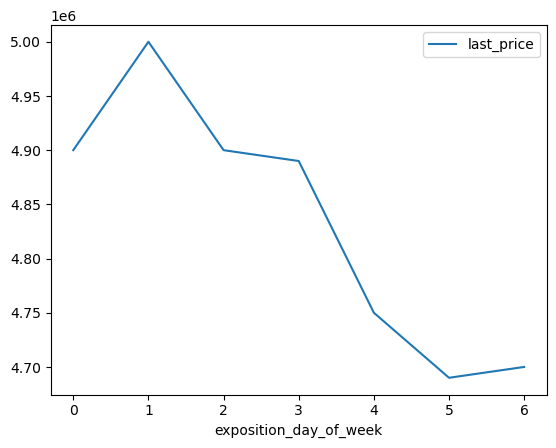

In [54]:
data.groupby('exposition_day_of_week').median()['last_price'].reset_index().sort_values(by='exposition_day_of_week')
data.groupby('exposition_day_of_week').median()['last_price'].reset_index().sort_values(by='exposition_day_of_week').plot(x='exposition_day_of_week')

,exposition_month,last_price
0,1,4900000.0
1,2,4900000.0
2,3,4700000.0
3,4,5000000.0
4,5,4800000.0
5,6,4600000.0
6,7,4950000.0
7,8,4900000.0
8,9,4850000.0
9,10,4795000.0


<AxesSubplot:xlabel='exposition_month'>

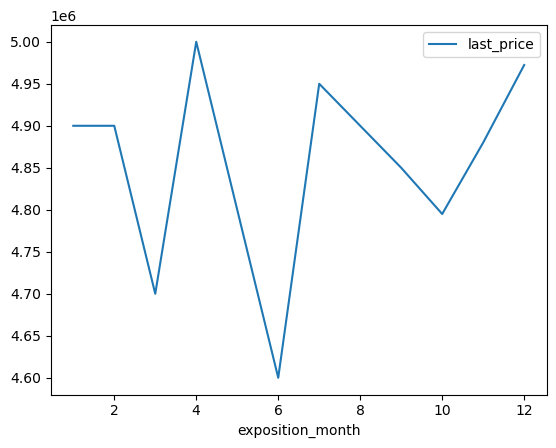

In [55]:
data.groupby('exposition_month').median()['last_price'].reset_index().sort_values(by='exposition_month')
data.groupby('exposition_month').median()['last_price'].reset_index().sort_values(by='exposition_month').plot(x='exposition_month')

,exposition_year,last_price
0,2014,7950000.0
1,2015,5602774.0
2,2016,4840000.0
3,2017,4700000.0
4,2018,4700000.0
5,2019,5200000.0


<AxesSubplot:xlabel='exposition_year'>

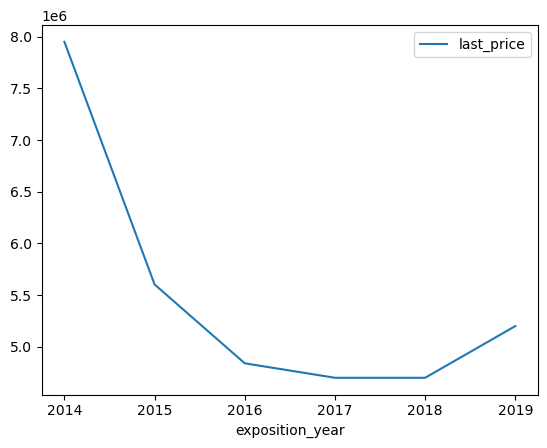

In [56]:
data.groupby('exposition_year').median()['last_price'].reset_index().sort_values(by='exposition_year')
data.groupby('exposition_year').median()['last_price'].reset_index().sort_values(by='exposition_year').plot(x='exposition_year')

Больше всего цена зависит от от площади квартиры. Квартиры на первом этаже в среднем дешевле квартир на других этажах. 
В выходные цены на недвижимость заметно ниже чем в буднии дни. Возможно это связанно с тем что в выходные публикаций больше от
частных лиц а не от агенств. Зависимость стоимости квартиры от количества комнат достаточно вилика но ниже чем от общей площади квартиры.

In [57]:
data['rooms'].corr(data['total_area'])


0.761019437379057

In [58]:
data.groupby('locality_name')['price_per_smeter'].agg(['mean', 'count']).sort_values(by='count',ascending=False).head(10)

,mean,count
locality_name,,
Санкт-Петербург,115704.997757,10084
Всеволожск,67434.629936,271
Пушкин,103920.487928,234
поселок Шушары,79538.627641,217
поселок Мурино,87085.571849,212
Колпино,75938.525561,203
Гатчина,70024.959358,148
Петергоф,85554.144673,145
поселок Парголово,90901.351145,137


В Санкт-Петербурге и Пушкине(официально является районом Спб) цены на недвижимость самые высокие. Кудрово также находится в черте КАД и этот район города было бы правильно отнести к Спб. Чем удаленней субьекты Лен. области от Санкт-Петербурга тем дешевле стоимось недвижимости.

In [59]:
#data['price_per_km'] = data[data['locality_name'] == 'Санкт-Петербург']['last_price'] / data[data['locality_name'] == 'Санкт-Петербург']['city_сenters_nearest_km']
#data.query("locality_name == 'Санкт-Петербург'").sort_values(by='city_сenters_nearest_km', ascending=True)
dt = data.query("locality_name == 'Санкт-Петербург'").groupby('city_сenters_nearest_km').median().reset_index()
dt

,city_сenters_nearest_km,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_сenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_smeter,exposition_day_of_week,exposition_month,exposition_year
0,0,11.0,11500000.0,96.900,3.0,3.200,5.0,50.300,3.0,0.0,...,649.0,2.0,405.5,2.0,251.0,127.5,139318.885449,2.0,8.0,2017.0
1,1,10.0,11500000.0,93.000,3.0,3.200,5.0,58.000,3.0,0.0,...,1429.0,2.0,430.5,3.0,161.0,197.0,123728.813559,3.0,7.0,2017.0
2,2,11.0,9500000.0,87.600,3.0,3.200,5.0,52.800,3.0,0.0,...,2418.0,1.0,348.0,2.0,295.0,131.0,113464.447806,3.0,6.0,2017.0
3,3,10.0,8945000.0,81.400,3.0,3.100,5.0,49.700,3.0,0.0,...,3512.0,1.0,456.0,1.0,541.5,172.0,110403.449643,2.0,7.0,2017.0
4,4,10.0,10000000.0,85.000,3.0,3.000,6.0,50.000,4.0,0.0,...,4553.0,1.0,454.0,1.0,531.0,151.0,125980.424144,2.0,6.0,2017.0
5,5,10.0,9000000.0,79.000,3.0,3.000,6.0,46.000,4.0,0.0,...,5467.0,1.0,411.0,1.0,463.0,139.0,125303.942051,2.0,6.0,2017.0
6,6,10.0,7450000.0,67.935,2.0,3.000,7.0,36.000,4.0,0.0,...,6447.0,1.0,375.0,1.0,477.0,123.0,127612.703695,2.0,6.0,2018.0
7,7,11.0,7000000.0,61.900,2.0,2.750,8.0,37.500,4.0,0.0,...,7489.0,1.0,480.5,1.0,380.0,110.0,125000.000000,3.0,7.0,2018.0
8,8,9.0,6995000.0,62.250,2.0,2.800,9.0,35.900,4.0,0.0,...,8460.0,1.0,441.0,1.0,454.0,90.0,119424.283976,2.0,6.0,2018.0
9,9,10.0,5200000.0,50.300,2.0,2.700,8.0,30.000,4.0,0.0,...,9551.0,1.0,497.0,0.0,528.0,96.0,107317.073171,2.0,5.0,2018.0


<AxesSubplot:xlabel='city_сenters_nearest_km'>

7229.768997246498

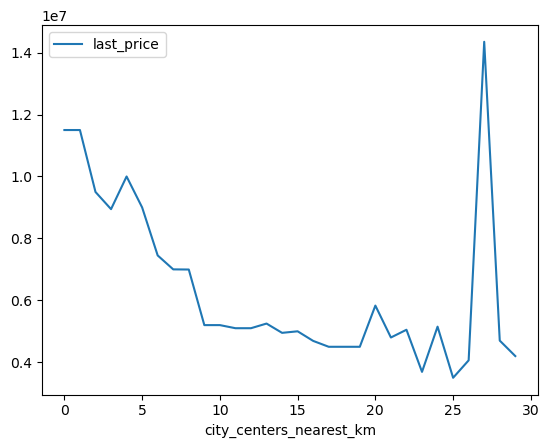

In [60]:
dt['price_km'] =dt['price_per_smeter'] / dt['city_сenters_nearest_km']
dt.plot(x='city_сenters_nearest_km', y='last_price')
dt['price_km'].median()

По отношению к Санк-Петербургу можно сказать что зависимость стоимости жилья от удаления от центра является самой релевантной. 
На графике видно что стоимось снижается до 17-18 километров в удалении от центра. Это то самое рассояние от центра до КАД. 
В ближайшем отдалении от кад находятся частный сектор с дорогой недвижимостью поэтому цена снова ростет.

### Общий вывод

Изучив всевозможные зависимости цены недвижимости от различных параметров и условий можно сделать вывод что лучше всего изучать 
цены не по общей стоимости обьекта недвижимости, а по стоимости квадратного метра. Все описанные зависимости достаточно точно и реалестично описывают реальную картину на рынке недвижимости.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод